In [1]:
import math
import numpy as np
import numpy.random as rand
import scipy.stats as stat
from scipy.interpolate import Rbf
# ------------------------------
from numba import cuda, vectorize
# ------------------------------
import matplotlib.pyplot as plt

In [2]:
head = lambda x: x[0:6]
tail = lambda x: x[-6:]
# ------------------------------
point_dtype = np.dtype({
    'names':   ['x', 'y'],
    'formats': [np.float32, np.float32]})

# Prepare data points

In [3]:
dat_pts = np.array([rand.random(50), rand.random(50)])
dat_pts = dat_pts.T
head(dat_pts)

array([[0.25605289, 0.71170015],
       [0.90155253, 0.84557878],
       [0.31087869, 0.04558894],
       [0.66260862, 0.80308675],
       [0.83101059, 0.17149252],
       [0.63104782, 0.87080652]])

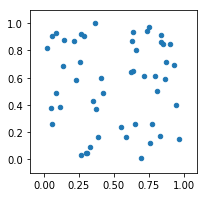

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(3,3))

axes.scatter(
    x = dat_pts[:, 0],
    y = dat_pts[:, 1],
    s = 20)

axes.set_xlim(-0.1, 1.1)
axes.set_ylim(-0.1, 1.1)
plt.show()

# Prepare grid point

## Distribution

In [7]:
distr = stat.multivariate_normal(mean = [0.5, 0.5], cov=np.eye(2))

In [12]:
value = np.apply_along_axis(distr.pdf, 1, dat_pts)
print(value.shape)

(50,)


## set grid points and get value from distribution

In [9]:
# set up coordinates
x_c = np.linspace(0, 1, 50)
y_c = np.linspace(0, 1, 50)
x_c, y_c = np.meshgrid(x_c, y_c)

pos = np.empty(x_c.shape + (2,))
pos[:, :, 0] = x_c; pos[:, :, 1] = y_c

# get z value from multivariate binomial
z_c = distr.pdf(pos)

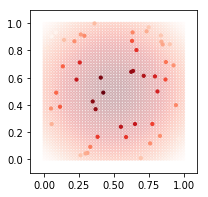

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(3,3))

# grid points
axes.scatter(x = x_c, y = y_c, c = z_c, s = 5, cmap = "Reds", alpha = 0.2) #cmap='Blues')

# data points
axes.scatter(
    x = dat_pts[:, 0], 
    y = dat_pts[:, 1], 
    s = 10, c = value, 
    cmap = "Reds")

axes.set_xlim(-0.1, 1.1)
axes.set_ylim(-0.1, 1.1)
plt.show()

# Try Interpolation by Rdf

In [13]:
rbfi = Rbf(dat_pts[:, 0], dat_pts[:, 1], value, function='multiquadric', smooth=1)
z_rbf = rbfi(x_c, y_c)
z_rbf.shape

(50, 50)

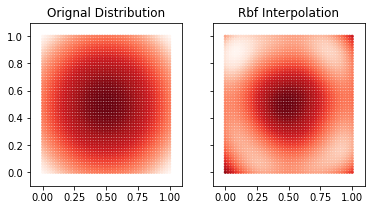

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex = True, sharey = True)

# bivariate normal
axes[0].scatter(x = x_c, y = y_c, c = z_c, s = 5, cmap = "Reds", alpha = 1) #cmap='Blues')
axes[0].set_title("Orignal Distribution")

# interpolation by Rbf
axes[1].scatter(x = x_c, y = y_c, c = z_rbf, s = 5, cmap = "Reds", alpha = 1) #cmap='Blues')
axes[1].set_title("Rbf Interpolation")

axes[0].set_xlim(-0.1, 1.1)
axes[0].set_ylim(-0.1, 1.1)
plt.show()

# Try my Interpolation

## 01 ufunc to calculate pairwise Distance

### small example for vectorize

In [31]:
@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [33]:
a = np.array([1, 2, 3, 4], dtype = np.float32)
b = np.array([10, 20, 30, 40], dtype = np.float32)
add_ufunc(a, b)

array([11., 22., 33., 44.], dtype=float32)

### Define function to calculate distance

In [44]:
def dist2(p_x, p_y, x, y):
    """calculate the distance between the point (x, y) and input point"""
    return np.power(p_x - x, 2) + np.power(p_y - y, 2)


@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def dist2_ufunc(p_x, p_y, x, y):
    """calculate the distance between the point (x, y) and input point"""
    return math.pow(p_x - x, 2) + math.pow(p_y - y, 2)
    #return math.pow(point["x"] - x, 2) + math.pow(point["y"] - y, 2)

### Check if the function work correctly

In [45]:
x = dat_pts[:, 0].astype(np.float32)
y = dat_pts[:, 1].astype(np.float32)

np.allclose(dist2(x, y, 0.0, 0.0), dist2_ufunc(x, y, 0.0, 0.0))

True

### Try Larger test data to time function

In [52]:
n = 1000000
# ----------------------
a = np.random.random(n).astype(np.float32)
b = np.random.random(n).astype(np.float32)
# ----------------------
a_device   = cuda.to_device(a)
b_device   = cuda.to_device(b)
out_device = cuda.device_array(shape=(n,), dtype=np.float32)

In [53]:
print("Numpy")
%timeit dist2(a, b, 0.0, 0.0)

print("GPU (CPU input/output arrays)")
%timeit dist2_ufunc(a, b, 0.0, 0.0)

print("GPU (GPU input/output arrays)")
%timeit dist2_ufunc(a_device, b_device, 0.0, 0.0, out = out_device); out_host = out_device.copy_to_host()

Numpy
13.2 ms ± 1.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
GPU (CPU input/output arrays)
5.02 ms ± 46 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
GPU (GPU input/output arrays)
2.03 ms ± 5.83 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 02 Interpolation of one marker (weight := 1 / exp{dist2})

### Small example for slow matrix multiplication implementation
[reference for block and thread size in 2D matrix](https://stackoverflow.com/questions/35051998/very-slow-numba-cuda-in-python)

In [114]:
def expadd(arr_a, arr_b):
    return np.exp(arr_a) + np.exp(arr_b)

@cuda.jit #("void(float32[:, :], float32[:, :], float32[:, :])")
def expadd_gpu(arr_a, arr_b, arr_out):
    """addition of exponential matrix"""
    # thread coordinate system
    x, y = cuda.grid(2)
    
    # function addition
    arr_out[x, y] = math.exp(arr_a[x, y]) + math.exp(arr_b[x, y])

In [115]:
n_dim = 1000
n     = n_dim**2
# -------------------
#threadsperblock = 128
#blockspergrid   = int(math.ceil(float(n) / thread_ct))

threadsperblock = (32,32)
blockspergrid_x = math.ceil(n_dim / threadsperblock[0])
blockspergrid_y = math.ceil(n_dim / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [117]:
A = rand.random(n_dim**2).reshape(n_dim, n_dim)
B = rand.random(n_dim**2).reshape(n_dim, n_dim)
C = np.zeros_like(A)

expadd_gpu[blockspergrid, threadsperblock](A, B, C)
np.allclose(expadd(A, B), C)

True

In [119]:
A_device   = cuda.to_device(A)
B_device   = cuda.to_device(B)
out_device = cuda.device_array(shape=(A.shape), dtype=np.float32)

In [120]:
print("Numpy")
%timeit expadd

print("GPU (CPU input/output arrays)")
%timeit expadd_gpu[blockspergrid, threadsperblock](A, B, C)

print("GPU (GPU input/output arrays)")
%timeit expadd_gpu[blockspergrid, threadsperblock](A_device, B_device, out_device); out_host = out_device.copy_to_host()

Numpy
15.3 ns ± 0.173 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
GPU (CPU input/output arrays)
10 ms ± 43 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
GPU (GPU input/output arrays)
1.04 ms ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Simple Interpolation

In [122]:
value

array([0.15106567, 0.13831638, 0.14099862, 0.1500137 , 0.14275582,
       0.14731052, 0.15588132, 0.14046591, 0.13819066, 0.15145634,
       0.13919846, 0.14944817, 0.1468136 , 0.13811342, 0.14503465,
       0.15766558, 0.15153521, 0.15362293, 0.14802779, 0.15630429,
       0.14182798, 0.14614763, 0.14257913, 0.14978168, 0.14337548,
       0.15300192, 0.14321441, 0.13280073, 0.15282878, 0.1404796 ,
       0.14880828, 0.14292706, 0.13907054, 0.14641002, 0.14040951,
       0.1429426 , 0.14106661, 0.14433077, 0.14359586, 0.13999781,
       0.14269383, 0.13841445, 0.1384446 , 0.15869978, 0.15690582,
       0.15643805, 0.1340262 , 0.13297402, 0.15453216, 0.13512713])

In [192]:
def interpolation(pts_x, pts_y, value, grids_x, grids_y, grids_z):
    """interpolation"""
    dim = grids_x.shape
    
    for idx_x in range(dim[0]):
        for idx_y in range(dim[1]):
            distance2 = dist2(pts_x, pts_x, grids_x[idx_x, idx_y], grids_y[idx_x, idx_y])
            weight = np.exp(-distance2)
            grids_z[idx_x, idx_y] = np.sum(value * weight)


@cuda.jit('float32(float32, float32, float32, float32)', device = True)
def dist2_gpu(p_x, p_y, x, y):
    """calculate the distance between the point (x, y) and input point"""
    return math.pow(p_x - x, 2) + math.pow(p_y - y, 2)
    #return math.pow(point["x"] - x, 2) + math.pow(point["y"] - y, 2)            
            
@cuda.jit    
def interpolation_gpu(pts_x, pts_y, value, grids_x, grids_y, grids_z):
    """addition of exponential matrix"""
    # thread coordinate system
    idx_x, idx_y = cuda.grid(2)
    
    #
    grid_value = 0
    for idx in range(len(value)):
        distance2 = dist2_gpu(pts_x[idx], pts_x[idx], grids_x[idx_x, idx_y], grids_y[idx_x, idx_y])
        weight = math.exp(-distance2)
        grid_value += (value[idx] * weight)
        
    grids_z[idx_x, idx_y] = grid_value

### Check if the function works correctly

In [201]:
z_test = np.zeros_like(x_c)
interpolation(dat_pts[:, 0], dat_pts[:, 1], value, x_c, y_c, z_test)

In [202]:
print(z_test.shape)
print(z_test.size)

(50, 50)
2500


In [203]:
n_dim = z_test.shape[0]
n     = z_test.size
# -------------------
threadsperblock = (32,32)
blockspergrid_x = math.ceil(n_dim / threadsperblock[0])
blockspergrid_y = math.ceil(n_dim / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [204]:
z_test_gpu = np.zeros_like(x_c, dtype = np.float32)

interpolation_gpu[blockspergrid, threadsperblock](
    dat_pts[:, 0].astype(np.float32), 
    dat_pts[:, 1].astype(np.float32), 
    value.astype(np.float32), 
    x_c.astype(np.float32), 
    y_c.astype(np.float32), z_test_gpu)

np.allclose(z_test, z_test_gpu)

True

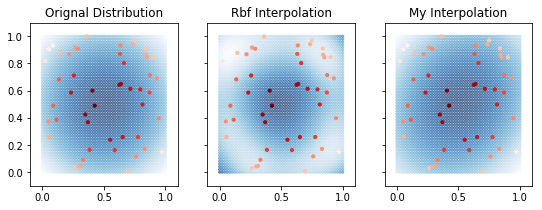

In [205]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex = True, sharey = True)

# bivariate normal
axes[0].scatter(x = x_c, y = y_c, c = z_c, s = 5, cmap = "Blues", alpha = 0.5)
axes[0].scatter(x = dat_pts[:, 0], y = dat_pts[:, 1], s = 10, c = value, cmap = "Reds")
axes[0].set_title("Orignal Distribution")

# interpolation by Rbf
axes[1].scatter(x = x_c, y = y_c, c = z_rbf, s = 5, cmap = "Blues", alpha = 0.5)
axes[1].scatter(x = dat_pts[:, 0], y = dat_pts[:, 1], s = 10, c = value, cmap = "Reds")
axes[1].set_title("Rbf Interpolation")

# my simple interpolation
axes[2].scatter(x = x_c, y = y_c, c = z_test, s = 5, cmap = "Blues", alpha = 0.5)
axes[2].scatter(x = dat_pts[:, 0], y = dat_pts[:, 1], s = 10, c = value, cmap = "Reds")
axes[2].set_title("My Interpolation")


axes[0].set_xlim(-0.1, 1.1)
axes[0].set_ylim(-0.1, 1.1)
plt.show()

### Benchmark

"Numpy"

In [207]:
%%timeit 
interpolation(dat_pts[:, 0], dat_pts[:, 1], value, x_c, y_c, z_test)

27.8 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


GPU (CPU input/output arrays)

In [208]:
%%timeit
interpolation_gpu[blockspergrid, threadsperblock](
    dat_pts[:, 0].astype(np.float32), 
    dat_pts[:, 1].astype(np.float32), 
    value.astype(np.float32), 
    x_c.astype(np.float32), 
    y_c.astype(np.float32), z_test_gpu)

2.44 ms ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


GPU (GPU input/output arrays)

In [211]:
x_device = cuda.to_device(dat_pts[:, 0].astype(np.float32))
y_device = cuda.to_device(dat_pts[:, 1].astype(np.float32)) 
z_device = cuda.to_device(value.astype(np.float32))
xc_device = cuda.to_device(x_c.astype(np.float32))
yc_device = cuda.to_device(y_c.astype(np.float32))
out_device = cuda.device_array(shape=(x_c.shape), dtype=np.float32)

In [212]:
%%timeit
interpolation_gpu[blockspergrid, threadsperblock](
    x_device, 
    y_device, 
    z_device, 
    xc_device, 
    yc_device, 
    out_device)

out_host = out_device.copy_to_host()

1.36 ms ± 526 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**Compare to the Rbf function**

In [213]:
%%timeit
rbfi = Rbf(dat_pts[:, 0], dat_pts[:, 1], value, function='multiquadric', smooth=1)
z_rbf = rbfi(x_c, y_c)

1.57 ms ± 6.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [44]:
import numba
import math
import numpy as np
import numpy.random as rand
import scipy.stats as stat
import matplotlib.pyplot as plt

In [ ]:
@numba.guvectorize(['void(float32[:, :])'],
    '(m, n), (n, p) -> (n, p)', 
    target = "cuda")
def batch_matrix_mult(a, b, c):
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            tmp = 0
            for n in range(a.shape[1]):
                tmp += a[i, n] * b[n, j]
            c[i, j] = tmp

In [11]:
@numba.guvectorize(['void(float32[:, :], float32, float32[:, :])'], '(m, p), ()->(n, n)', target = "cuda")
def interpolation(points, num_grids, grids):
    # intialization
    num_points = points.shape[0]
    
    # foreach grid
    for x in range(num_grids):
        for y in range(num_grids):
            
            # initialization
            grid_val = 0
            
            # for each point
            for idx_pt in range(num_points):
                pt_x   = points[idx_pt, 0]
                pt_y   = points[idx_pt, 1]
                pt_val = points[idx_pt, 2]
                dist2  = (pt_x - x)**2 + (pt_y - y)**2
                grid_val += (pt_val * math.exp(-1 * dist2))
            
            # assign to the grid points   
            grids[x, y] = grid_val

NameError: undefined output symbols: n

In [12]:
@numba.guvectorize(
    ['void(float32[:, :], float32, float32, float32[:])'], 
    '(m, p), (), ()->(m,)', 
    target = "cuda")
def interpolation(points, x, y, out):
    # intialization
    num_points = points.shape[0]
    
    # for each point
    for idx_pt in range(num_points):
        pt_x   = points[idx_pt, 0]
        pt_y   = points[idx_pt, 1]
        pt_val = points[idx_pt, 2]
        dist2  = (pt_x - x)**2 + (pt_y - y)**2
        grid_val = (pt_val * math.exp(-1 * dist2))
            
        # assign to the grid points   
        out[idx_pt] = grid_val

In [19]:
stat.norm.pdf(0.5, loc = 0.5, scale = 1)

0.3989422804014327

In [29]:
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)
X = np.ravel(X)
Y = np.ravel(Y)

In [100]:
distr = stat.multivariate_normal([0.5, 0.5], cov = 1)
x, y = np.mgrid[0:1:.01, 0:1:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y


In [106]:
x.shape + (2,)

(100, 100, 2)

In [102]:
x.shape

(100, 100)

In [104]:
distr.pdf(pos).shape

(100, 100)

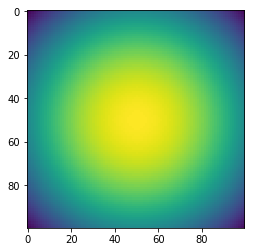

In [49]:
distr = stat.multivariate_normal([0.5, 0.5], cov = 1)
x, y = np.mgrid[0:1:.01, 0:1:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y


plt.imshow(distr.pdf(pos))

plt.show()

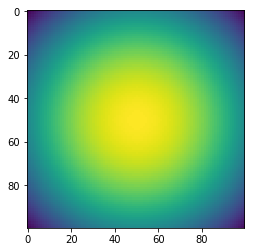

In [26]:
x = rand.uniform(low = 0, high = 1, size = 10)
y = rand.uniform(low = 0, high = 1, size = 10)
z = stat.multivariate_normal.pdf(x, loc = 0.5, scale = 1)**2 + 
z

array([0.1469955 , 0.15732933, 0.14126692, 0.15018866, 0.15912849,
       0.14631665, 0.14687488, 0.13272357, 0.13042669, 0.13873657])

In [ ]:
# foreach grid
for x in range(num_grids):
    for y in range(num_grids):
        out = interpolation(points, x, y)
        print(out)